All code and analysis by Lisa M. Dratva, 2024, ld21@sanger.ac.uk

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import celltypist
import pickle
import collections
import datetime
from scipy import stats
import celltypist
import cell2tcr
from statannotations.Annotator import Annotator

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import collections


savedir = '/nfs/team205/ld21/renal/figures/tcr/'
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['pdf.fonttype'] = 42

/home/jovyan/my-conda-envs/scVI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TCR analysis

In [2]:
adata = sc.read_h5ad('/nfs/team205/ld21/renal/renal_covid.h5ad')
adata.shape

# subset samples
erin_list = pd.read_csv('/nfs/team205/ld21/renal/data/Erin_final_object_subjects.tsv', sep='\t')
df = erin_list.sample_id.str.split('_', expand=True)
df[1] = df[1].str[:4]
erin_list['new_sample_id'] = df[0] + '_' + df[1]

adata = adata[adata.obs_names.isin(erin_list.cell_id)]
adata.shape

(577342, 33559)

In [ ]:
# make date_first_swab unique (was nan for some that had a date)
swab_date_dict = adata.obs[['patient_id','date_positive_swab']].drop_duplicates().sort_values('date_positive_swab').drop_duplicates('patient_id').set_index('patient_id').date_positive_swab.to_dict()
adata.obs['date_positive_swab_new'] = adata.obs.patient_id.map(swab_date_dict)

# days since positive swab
adata.obs['date_positive_swab_datetime'] = adata.obs.date_positive_swab_new.apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') if isinstance(x, str) else x)
adata.obs['date_sample_datetime'] = adata.obs.sample_date.apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') if isinstance(x, str) else x)
adata.obs['days_since_posswab_new'] = adata.obs.apply(lambda row: row.date_sample_datetime - row.date_positive_swab_datetime, axis=1)
adata.obs['days_since_posswab_new'] = adata.obs['days_since_posswab_new'].apply(lambda x: x.days)

# days since symptoms
adata.obs['date_symptoms_datetime'] = adata.obs.date_first_symptoms.apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') if isinstance(x, str) else x)
adata.obs['date_sample_datetime'] = adata.obs.sample_date.apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') if isinstance(x, str) else x)
adata.obs['days_since_symptoms_new'] = adata.obs.apply(lambda row: row.date_sample_datetime - row.date_symptoms_datetime, axis=1)
adata.obs['days_since_symptoms_new'] = adata.obs['days_since_symptoms_new'].apply(lambda x: x.days)

adata.obs.patient_id = adata.obs.patient_id.astype(str)

## T cell expansion

In [ ]:
adata.obs.IR_VJ_1_cdr3_tcr.fillna('', inplace=True)
adata.obs.IR_VDJ_1_cdr3_tcr.fillna('', inplace=True)
adata = adata[(adata.obs.IR_VJ_1_cdr3_tcr!='')&(adata.obs.IR_VDJ_1_cdr3_tcr!='')] # subset to T cells with resolved TCR
adata.obs['covid_patient'] = ~adata.obs['date_positive_swab_new'].isna()
adata.obs['has_longitudinal'] = adata.obs.patient_id.map((adata.obs.groupby('patient_id').sample_date.nunique()>1).to_dict())
adata.obs['clone_id'] = adata.obs.groupby(['patient_id','IR_VJ_1_cdr3_tcr', 'IR_VDJ_1_cdr3_tcr'], sort=False).ngroup()
adata.obs['sample_clone_id'] = adata.obs.groupby(['sample_id','IR_VJ_1_cdr3_tcr', 'IR_VDJ_1_cdr3_tcr'], sort=False).ngroup()
adata.obs['n_t_cells'] = adata.obs.sample_id.map(adata.obs.sample_id.value_counts().to_dict())
adata.obs['n_tcrs'] = adata.obs.sample_id.map(adata.obs.groupby('sample_id').nunique().clone_id.to_dict())

adata.obs['clone_multiplicity'] = adata.obs.sample_clone_id.map(adata.obs.sample_clone_id.value_counts().to_dict())
adata.obs['clone_freq'] = adata.obs.clone_multiplicity/adata.obs.n_t_cells
adata.obs.clone_id = adata.obs.clone_id.astype(str)
adata.obs['clone_is_longitudinal'] = adata.obs.clone_id.map((adata.obs.groupby('clone_id').days_since_posswab_new.nunique()>1).to_dict())

0 AxesSubplot(0.125,0.71587;0.352273x0.16413)
7277
2 AxesSubplot(0.547727,0.71587;0.352273x0.16413)
7142
4 AxesSubplot(0.125,0.518913;0.352273x0.16413)
5699
6 AxesSubplot(0.547727,0.518913;0.352273x0.16413)
4492
8 AxesSubplot(0.125,0.321957;0.352273x0.16413)
3474
10 AxesSubplot(0.547727,0.321957;0.352273x0.16413)
2814
12 AxesSubplot(0.125,0.125;0.352273x0.16413)
2039
14 AxesSubplot(0.547727,0.125;0.352273x0.16413)
1416


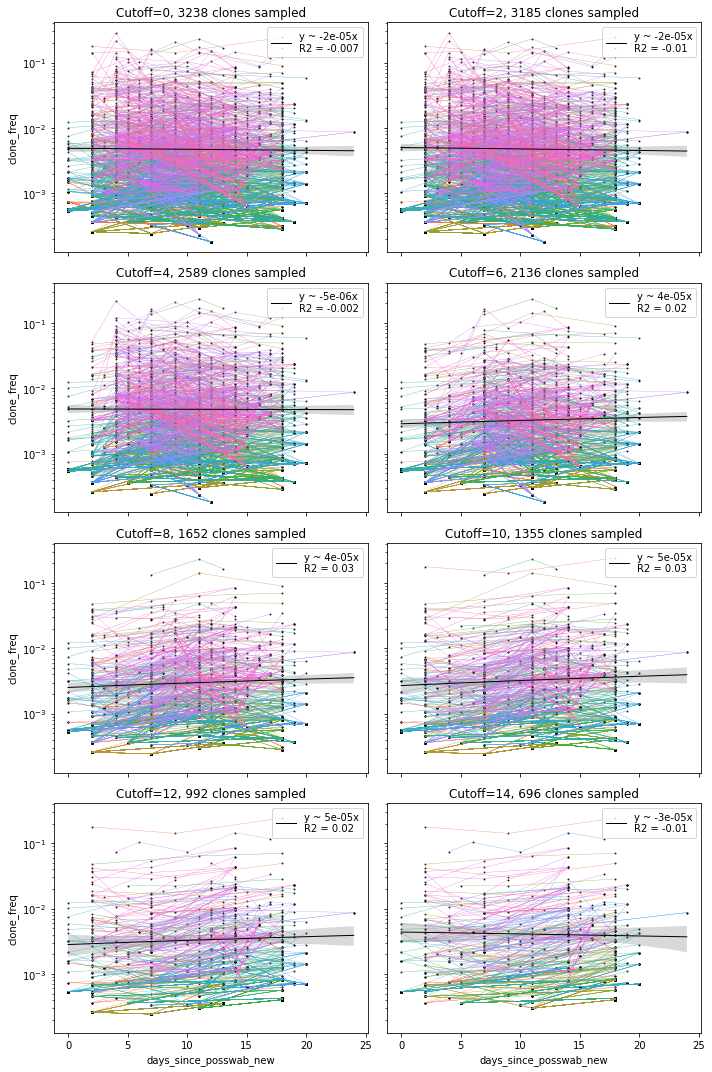

In [243]:
# SEARCH FOR 1 CUTOFF TO DETERMINE INCREASE
# RESULT : something between 6-8 keeps plenty of clones while not having
# clones that have low frequency before day 3 and high frequency after day 10
# compare: highest frequency at or before day 3 to lowest frequency at or after day 10
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15), sharey=True, sharex=True, )
for cutoff, ax in zip([0,2,4,6,8,10,12,14], axes.flatten()):
    print(cutoff, ax)
    freq_highest_early_dict = adata[adata.obs.days_since_posswab_new<cutoff].obs.groupby('clone_id').max().clone_freq.to_dict()
    freq_lowest_late_dict = adata[adata.obs.days_since_posswab_new>=cutoff].obs.groupby('clone_id').min().clone_freq.to_dict()
    adata.obs['freq_highest_early'] = adata.obs.clone_id.apply(lambda x: freq_highest_early_dict[x] if x in freq_highest_early_dict.keys() else 0)
    adata.obs['freq_lowest_late'] = adata.obs.clone_id.apply(lambda x: freq_lowest_late_dict[x] if x in freq_lowest_late_dict.keys() else 0)
    adata.obs['freq_increasing_early_late'] = adata.obs.freq_lowest_late > adata.obs.freq_highest_early
    
    data = adata[
        (adata.obs.freq_increasing_early_late)&(adata.obs.clone_is_longitudinal)&
    #     (adata.obs.clone_id.isin(adata.obs.groupby('clone_id').days_since_posswab_new.nunique().reset_index().query('days_since_posswab_new>1').clone_id.unique()))&
        (~adata.obs.clone_id.isin(adata[adata.obs.days_since_posswab_new<0].obs.clone_id.unique()))& # absent before day 0
        (adata.obs.days_since_posswab_new<=30) # present in this time window
    ].obs[['clone_id','clone_freq', 'days_since_posswab_new']].drop_duplicates()
    print(data.shape[0])
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['days_since_posswab_new'], data['clone_freq'])
    
    sns.lineplot(data=data, x='days_since_posswab_new', y='clone_freq', hue='clone_id', legend=None, sort=True, linewidth=0.3, ax=ax)
    sns.regplot(
        data=data, x='days_since_posswab_new', y='clone_freq', order=0, ax=ax, scatter_kws={'s':1,'color':'k'}, 
        line_kws={'color':'k', 'linewidth':1,'label':'y ~ {0:.1g}x\nR2 = {1:.1g}'.format(slope, r_value)},
        ).legend(loc='upper right')
    ax.set_title(f'Cutoff={cutoff}, {data.clone_id.nunique()} clones sampled')
plt.yscale('log')
plt.tight_layout()
plt.savefig(savedir+'increase_cutoff_search')
plt.show()

### Dual-cutoff expansion

In [ ]:
# focus: cutoff = 6,8,10
for cutoff in [10]:
    fig, ax = plt.subplots(figsize=(6,4))
    print(cutoff)
    freq_highest_early_dict = adata[adata.obs.days_since_posswab_new<cutoff].obs.groupby('clone_id').max().clone_freq.to_dict()
    freq_lowest_late_dict = adata[adata.obs.days_since_posswab_new>=cutoff].obs.groupby('clone_id').min().clone_freq.to_dict()
    adata.obs['freq_highest_early'] = adata.obs.clone_id.apply(lambda x: freq_highest_early_dict[x] if x in freq_highest_early_dict.keys() else 0)
    adata.obs['freq_lowest_late'] = adata.obs.clone_id.apply(lambda x: freq_lowest_late_dict[x] if x in freq_lowest_late_dict.keys() else 0)
    adata.obs['freq_increasing_early_late'] = adata.obs.freq_lowest_late > adata.obs.freq_highest_early
    
    data = adata[
        (adata.obs.freq_increasing_early_late)&(adata.obs.clone_is_longitudinal)&
    #     (adata.obs.clone_id.isin(adata.obs.groupby('clone_id').days_since_posswab_new.nunique().reset_index().query('days_since_posswab_new>1').clone_id.unique()))&
        (~adata.obs.clone_id.isin(adata[adata.obs.days_since_posswab_new<0].obs.clone_id.unique()))& # absent before day 0
        (adata.obs.days_since_posswab_new<=30) # present in this time window
    ].obs[['clone_id','clone_freq', 'days_since_posswab_new']].drop_duplicates()
    print(data.shape[0])
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['days_since_posswab_new'], data['clone_freq'])
    
    sns.lineplot(data=data, x='days_since_posswab_new', y='clone_freq', hue='clone_id', legend=None, sort=True, linewidth=0.3, ax=ax)
    sns.regplot(
        data=data, x='days_since_posswab_new', y='clone_freq', order=0, ax=ax, scatter_kws={'s':1,'color':'k'}, 
        line_kws={'color':'k', 'linewidth':1,'label':'y ~ {0:.1g}x\nR2 = {1:.1g}'.format(slope, r_value)},
        ).legend(loc='upper right')
    ax.set_title(f'Cutoff={cutoff}, {data.clone_id.nunique()} clones sampled')
    plt.yscale('log')
    plt.xlabel('Days since positive swab')
    plt.tight_layout()
#     plt.savefig(savedir+f'increase_cutoff_{cutoff}.pdf')
    plt.show()

In [7]:
# clones that have low frequency before day 3 and high frequency after day 10
# compare: highest frequency at or before day 3 to lowest frequency at or after day 10
cutoff_early = 2
cutoff_late = 10
freq_highest_early_dict = adata[adata.obs.days_since_posswab_new<cutoff_early].obs.groupby('clone_id').clone_freq.max().to_dict()
freq_highest_mid_dict = adata[(adata.obs.days_since_posswab_new>=cutoff_early)&(adata.obs.days_since_posswab_new<cutoff_late)].obs.groupby('clone_id').clone_freq.max().to_dict()
freq_lowest_late_dict = adata[adata.obs.days_since_posswab_new>=cutoff_late].obs.groupby('clone_id').clone_freq.min().to_dict()

adata.obs['freq_highest_early'] = adata.obs.clone_id.apply(lambda x: freq_highest_early_dict[x] if x in freq_highest_early_dict.keys() else 0)
adata.obs['freq_highest_mid'] = adata.obs.clone_id.apply(lambda x: freq_highest_mid_dict[x] if x in freq_highest_mid_dict.keys() else 0)
adata.obs['freq_lowest_late'] = adata.obs.clone_id.apply(lambda x: freq_lowest_late_dict[x] if x in freq_lowest_late_dict.keys() else 0)
adata.obs['freq_increasing_early_late'] = adata.obs.freq_lowest_late > adata.obs.freq_highest_early
adata.obs['freq_increasing_early_mid_late'] = (adata.obs.freq_highest_early < adata.obs.freq_highest_mid) & (adata.obs.freq_highest_mid < adata.obs.freq_lowest_late)

2 10 AxesSubplot(0.125,0.71587;0.168478x0.16413)
1671
2 12 AxesSubplot(0.327174,0.71587;0.168478x0.16413)
1626
2 14 AxesSubplot(0.529348,0.71587;0.168478x0.16413)
1188
2 16 AxesSubplot(0.731522,0.71587;0.168478x0.16413)
980
4 10 AxesSubplot(0.125,0.518913;0.168478x0.16413)
1082
4 12 AxesSubplot(0.327174,0.518913;0.168478x0.16413)
1138
4 14 AxesSubplot(0.529348,0.518913;0.168478x0.16413)
965
4 16 AxesSubplot(0.731522,0.518913;0.168478x0.16413)
832
6 10 AxesSubplot(0.125,0.321957;0.168478x0.16413)
759
6 12 AxesSubplot(0.327174,0.321957;0.168478x0.16413)
885
6 14 AxesSubplot(0.529348,0.321957;0.168478x0.16413)
720
6 16 AxesSubplot(0.731522,0.321957;0.168478x0.16413)
626
8 10 AxesSubplot(0.125,0.125;0.168478x0.16413)
97
8 12 AxesSubplot(0.327174,0.125;0.168478x0.16413)
473
8 14 AxesSubplot(0.529348,0.125;0.168478x0.16413)
517
8 16 AxesSubplot(0.731522,0.125;0.168478x0.16413)
570


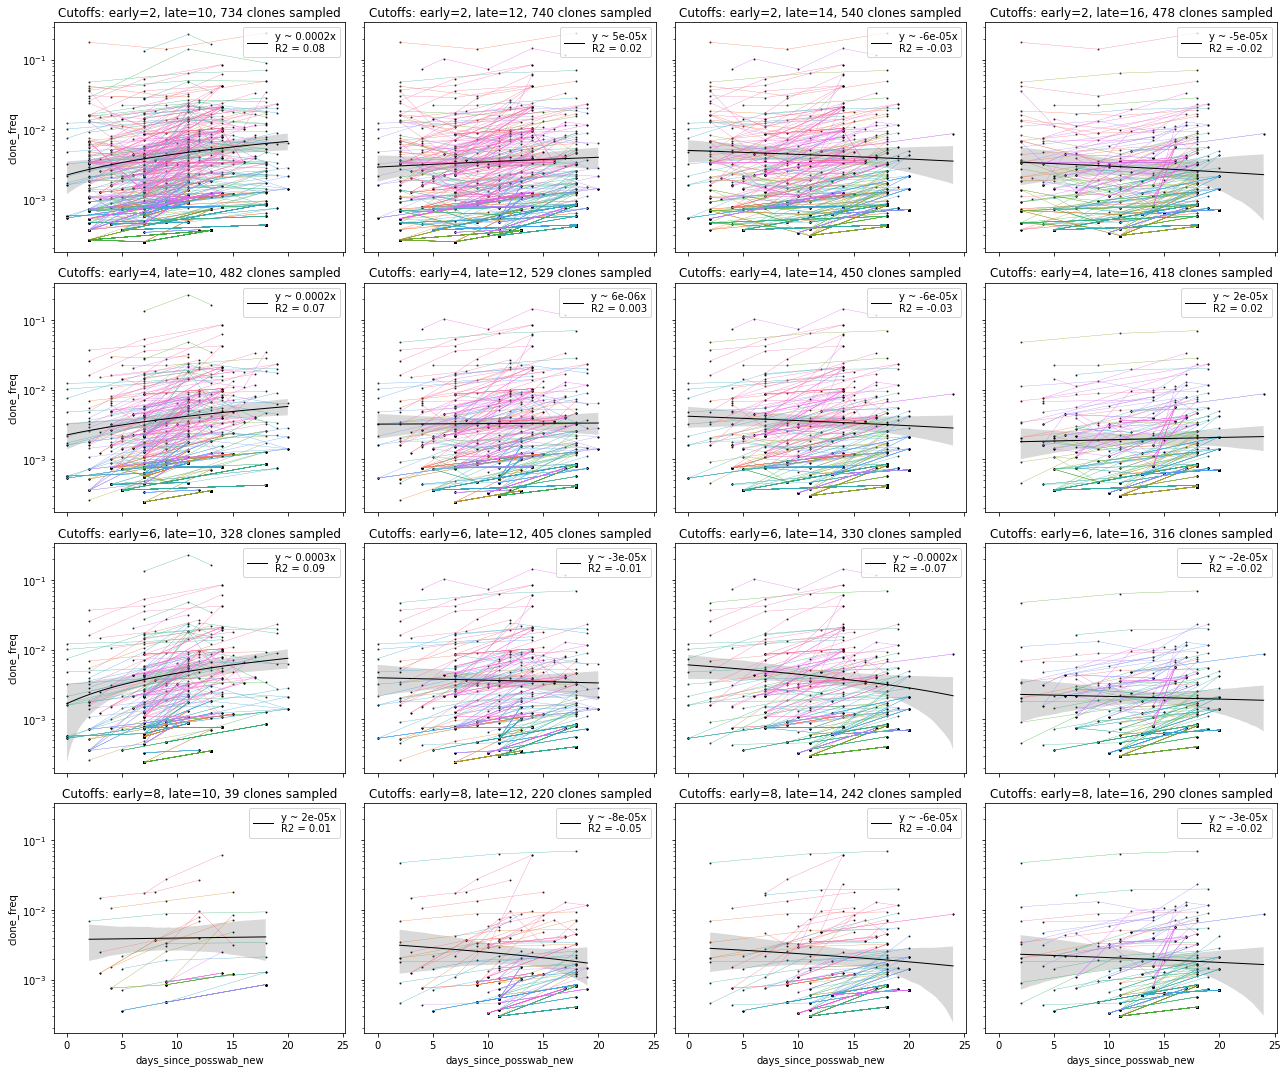

In [242]:
# SEARCH FOR 2 CUTOFFS TO DETERMINE INCREASE
# RESULT : 
# clones that have low frequency before day 3 and high frequency after day 10
# compare: highest frequency at or before day 3 to lowest frequency at or after day 10
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18,15), sharey=True, sharex=True, )
for i, cutoff_early in enumerate([2,4,6,8]):
    for j, cutoff_late in enumerate([10,12,14,16]):
        ax = axes[i,j]
        print(cutoff_early, cutoff_late, ax)
        freq_highest_early_dict = adata[adata.obs.days_since_posswab_new<cutoff_early].obs.groupby('clone_id').max().clone_freq.to_dict()
        freq_highest_mid_dict = adata[
            (adata.obs.days_since_posswab_new>=cutoff_early)&
            (adata.obs.days_since_posswab_new<cutoff_late)].obs.groupby('clone_id').max().clone_freq.to_dict()
        freq_lowest_late_dict = adata[adata.obs.days_since_posswab_new>=cutoff_late].obs.groupby('clone_id').min().clone_freq.to_dict()
        adata.obs['freq_highest_early'] = adata.obs.clone_id.apply(lambda x: freq_highest_early_dict[x] if x in freq_highest_early_dict.keys() else 0)
        adata.obs['freq_highest_mid'] = adata.obs.clone_id.apply(lambda x: freq_highest_mid_dict[x] if x in freq_highest_mid_dict.keys() else 0)
        adata.obs['freq_lowest_late'] = adata.obs.clone_id.apply(lambda x: freq_lowest_late_dict[x] if x in freq_lowest_late_dict.keys() else 0)
#         adata.obs['freq_increasing_early_late'] = adata.obs.freq_lowest_late > adata.obs.freq_highest_early
        adata.obs['freq_increasing_early_mid_late'] = (adata.obs.freq_highest_early < adata.obs.freq_highest_mid) & (adata.obs.freq_highest_mid < adata.obs.freq_lowest_late)

        data = adata[
            (adata.obs.freq_increasing_early_mid_late)&(adata.obs.clone_is_longitudinal)&
        #     (adata.obs.clone_id.isin(adata.obs.groupby('clone_id').days_since_posswab_new.nunique().reset_index().query('days_since_posswab_new>1').clone_id.unique()))&
            (~adata.obs.clone_id.isin(adata[adata.obs.days_since_posswab_new<0].obs.clone_id.unique()))& # absent before day 0
            (adata.obs.days_since_posswab_new<=30) # present in this time window
        ].obs[['clone_id','clone_freq', 'days_since_posswab_new']].drop_duplicates()
        print(data.shape[0])
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['days_since_posswab_new'], data['clone_freq'])
        sns.lineplot(data=data, x='days_since_posswab_new', y='clone_freq', hue='clone_id', legend=None, sort=True, linewidth=0.3, ax=ax)
        sns.regplot(
            data=data, x='days_since_posswab_new', y='clone_freq', order=0, ax=ax, scatter_kws={'s':1,'color':'k'}, 
            line_kws={'color':'k', 'linewidth':1,'label':'y ~ {0:.1g}x\nR2 = {1:.1g}'.format(slope, r_value)},
            ).legend(loc='upper right')
        ax.set_title(f'Cutoffs: early={cutoff_early}, late={cutoff_late}, {data.clone_id.nunique()} clones sampled')
plt.yscale('log')
plt.tight_layout()
plt.savefig(savedir+'increase_cutoff_early_late_search')
plt.show()

In [ ]:
# focus on cutoff_early 2, cutoff_late 10
fig, ax = plt.subplots(figsize=(6,4))
cutoff_early = 2
cutoff_late = 10
freq_highest_early_dict = adata[adata.obs.days_since_posswab_new<cutoff_early].obs.groupby('clone_id').max().clone_freq.to_dict()
freq_highest_mid_dict = adata[
    (adata.obs.days_since_posswab_new>=cutoff_early)&
    (adata.obs.days_since_posswab_new<cutoff_late)].obs.groupby('clone_id').max().clone_freq.to_dict()
freq_lowest_late_dict = adata[adata.obs.days_since_posswab_new>=cutoff_late].obs.groupby('clone_id').min().clone_freq.to_dict()
adata.obs['freq_highest_early'] = adata.obs.clone_id.apply(lambda x: freq_highest_early_dict[x] if x in freq_highest_early_dict.keys() else 0)
adata.obs['freq_highest_mid'] = adata.obs.clone_id.apply(lambda x: freq_highest_mid_dict[x] if x in freq_highest_mid_dict.keys() else 0)
adata.obs['freq_lowest_late'] = adata.obs.clone_id.apply(lambda x: freq_lowest_late_dict[x] if x in freq_lowest_late_dict.keys() else 0)
adata.obs['freq_increasing_early_late'] = adata.obs.freq_lowest_late > adata.obs.freq_highest_early
adata.obs['freq_increasing_early_mid_late'] = (adata.obs.freq_highest_early < adata.obs.freq_highest_mid) & (adata.obs.freq_highest_mid < adata.obs.freq_lowest_late)

data = adata[
    (adata.obs.freq_increasing_early_mid_late)&
    (adata.obs.clone_is_longitudinal)&
#     (adata.obs.clone_id.isin(adata.obs.groupby('clone_id').days_since_posswab_new.nunique().reset_index().query('days_since_posswab_new>1').clone_id.unique()))&
    (~adata.obs.clone_id.isin(adata[adata.obs.days_since_posswab_new<0].obs.clone_id.unique()))& # absent before day 0
    (adata.obs.days_since_posswab_new<=30) # present in this time window
].obs[['clone_id','clone_freq', 'days_since_posswab_new']].drop_duplicates()
print(data.shape[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(data['days_since_posswab_new'], data['clone_freq'])
sns.lineplot(data=data, x='days_since_posswab_new', y='clone_freq', hue='clone_id', legend=None, sort=True, linewidth=0.3, ax=ax)
sns.regplot(
    data=data, x='days_since_posswab_new', y='clone_freq', order=0, ax=ax, scatter_kws={'s':1,'color':'k'}, 
    line_kws={'color':'k', 'linewidth':1,'label':'y ~ {0:.1g}x\nR2 = {1:.1g}'.format(slope, r_value)},
    ).legend(loc='upper right')
ax.set_title(f'Cutoffs: early={cutoff_early}, late={cutoff_late}, {data.clone_id.nunique()} clones sampled')
plt.yscale('log')
plt.tight_layout()
plt.xlabel('Days since positive swab')
# plt.savefig(savedir+'increase_cutoff_early_2_late_10.pdf')
plt.show()

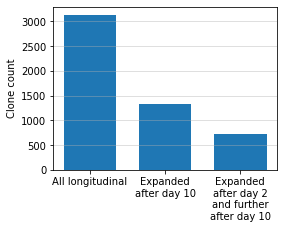

In [22]:
heights = [3137, 1332, 722]
h_labels = ['All longitudinal','Expanded\nafter day 10', 'Expanded\nafter day 2\nand further\nafter day 10']
plt.figure(figsize=(4,3))
plt.bar(range(3),heights, tick_label=h_labels, width=0.7)
plt.ylabel('Clone count')
plt.grid(axis='y', alpha=0.5)
plt.savefig(savedir+'expansion_bar')

## SARS-CoV-2 specificity


In [6]:
vdjdb = pd.read_csv('/nfs/team205/ld21/public/antigen/VDJDB_sars_cov_2.tsv', sep='\t')

adata.obs['vdjdb_paired'] = adata.obs.IR_VJ_1_cdr3_tcr.isin(vdjdb['CDR3']) & adata.obs.IR_VDJ_1_cdr3_tcr.isin(vdjdb['CDR3'])
adata.obs['vdjdb_alpha'] = adata.obs.IR_VJ_1_cdr3_tcr.isin(vdjdb['CDR3'])
adata.obs['vdjdb_beta'] = adata.obs.IR_VDJ_1_cdr3_tcr.isin(vdjdb['CDR3'])


In [ ]:
# CONDITIONS
# - sampled 1x or more before Day 10
# - sampled 1x or more on or after Day 10
# - calculate increase and look at those 2 STD above average

In [8]:
sampled_before_and_after_10 = set(adata[(adata.obs.days_since_posswab_new<10)].obs.clone_id).intersection(
    set(adata[(adata.obs.days_since_posswab_new>=10)&(adata.obs.days_since_posswab_new<25)].obs.clone_id))
previous_clones = set(adata[adata.obs.days_since_posswab_new<0].obs.clone_id)
sampled_before_and_after_10 -= previous_clones
len(sampled_before_and_after_10)

clone_day_df = adata[adata.obs.clone_id.isin(sampled_before_and_after_10)].obs[[
    'clone_id','days_since_posswab_new', 'patient_id', 
    'vdjdb_alpha','vdjdb_beta','vdjdb_paired','clone_freq','clone_multiplicity'
]].drop_duplicates().reset_index(drop=True)

clone_df = clone_day_df.groupby(['clone_id']).mean()
clone_df['freq_before_10'] = clone_day_df[clone_day_df.days_since_posswab_new<10].groupby(['clone_id']).clone_freq.mean()
clone_df['freq_after_10'] = clone_day_df[clone_day_df.days_since_posswab_new>=10].groupby(['clone_id']).clone_freq.mean()
clone_df['freq_increase'] = clone_df.freq_after_10/clone_df.freq_before_10
# clone_df#.sort_values('freq_increase').tail(30)

In [63]:
fractions = []
for i in np.arange(10, 2030, 5):
    x = [i]
    x.extend([clone_df.sort_values('freq_increase')[-i:][col].mean() for col in ['vdjdb_alpha','vdjdb_beta','vdjdb_paired']])
    fractions.append(x)

In [294]:
adata[adata.obs.clone_id.isin(adata[adata.obs.days_since_posswab_new<0].obs.clone_id.unique())].obs.groupby('clone_id').mean().mean().vdjdb

0.03304078471863707

### Check matches with SARS-CoV-2 database

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 47 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'J', 'M', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'c', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'u', 'w', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 27, 32, 36, 37, 38, 39, 41, 45, 48, 51, 53, 54, 55, 57, 58, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92]
Closed glyph list over 'GSUB': 52 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'J', 'M', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'c', 'd', 'e', 'eight', 'equal', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn'

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:1.484e-03 U_stat=1.909e+09


GPOS subsetted
GSUB subsetted
MATH subsetted
name subsetting not needed
glyf subsetted
head pruned
OS/2 Unicode ranges pruned: [0]
glyf pruned
GDEF pruned
GPOS pruned
GSUB pruned
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned


True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:6.137e-03 U_stat=4.835e+07


glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 48 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'J', 'M', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'c', 'd', 'e', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 32, 36, 37, 38, 39, 41, 45, 48, 51, 53, 54, 55, 57, 58, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92]
Closed glyph list over 'GSUB': 53 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'J', 'M', 'P', 'R', 'S', 'T', 'V', 'W', 'a', 'c', 'd', 'e', 'equal', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'uniFB

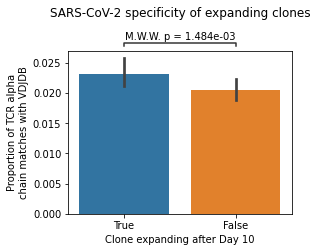

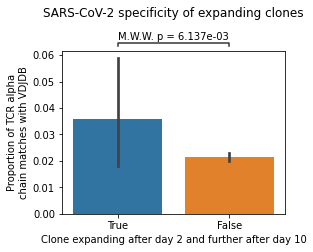

In [30]:
adata.obs['present_before_day_0'] = adata.obs.clone_id.isin(previous_clones)

# consider results by clone (not by cell)
data = adata.obs[[
    'patient_id','present_before_day_0','freq_increasing_early_late','freq_increasing_early_mid_late',
#     'iedb_paired','iedb_alpha','iedb_beta','vdjdb_alpha','vdjdb_beta','clone_id']].drop_duplicates()
    'iedb_alpha','vdjdb_alpha','clone_id']].drop_duplicates()
# data = data[~data.present_before_day_0]

### This figure looks at all T cells
# plt.style.use('seaborn-white')
# x = 'present_before_day_0'
# for x in ['present_before_day_0','freq_increasing_early_late','freq_increasing_early_mid_late']:
#     for y in ['iedb_paired','iedb_alpha','iedb_beta','vdjdb_alpha','vdjdb_beta']:
for x, x_label in zip(['freq_increasing_early_late','freq_increasing_early_mid_late'],['Clone expanding after Day 10', 'Clone expanding after day 2 and further after day 10']):
    for y in ['vdjdb_alpha']:
# x = 'freq_increasing_early_late'
# y = 'iedb_alpha'
#         plt.figure(figsize=(4,3))
#         ax = sns.barplot(
#             data=data, x=x, y=y, ci=None, 
#             order=[True, False]
#         )
#         annotator = Annotator(ax, [(True, False)], order=[True, False], data=data, x=x, y=y)
#         # annotator = Annotator(ax, [('Effector', 'Activated')], order=['Naive', 'Memory', 'Effector', 'Activated'], data=p_adata.obs, x='Broad type', y='in_iedb_alpha_beta')
#         annotator.configure(test='Mann-Whitney', text_format='full', loc='inside') # text_format: 'full','simple','star'
#         annotator.apply_and_annotate()
#         plt.title(f'{x}\nProportion of matches in {y}')
#         plt.savefig(savedir+y+'_'+x)
        
        plt.figure(figsize=(4,3))
        ax = sns.barplot(
            data=data, x=x, y=y,
            order=[True, False], units='patient_id')        
        annotator = Annotator(ax, [(True, False)], order=[True, False], data=data, x=x, y=y)
        annotator.configure(test='Mann-Whitney', text_format='full', loc='outside') # text_format: 'full','simple','star'
        annotator.apply_and_annotate()
        plt.title('SARS-CoV-2 specificity of expanding clones', y=1.17)
        plt.ylabel('Proportion of TCR alpha\nchain matches with VDJDB')
        plt.xlabel(x_label)
        plt.savefig(savedir+y+'_'+x+'_errorbars.pdf')

#         plt.figure()
#         sns.barplot(
#             data=data, x=x, y=y,# ci=None, 
#             order=[True, False], units='patient_id'
#                 )
#         ax = sns.pointplot(
#             data=data, x=x, y=y, hue='patient_id', join=True, dodge=0.1, ci=None,
#             order=[True, False], color='k', scale=.3
#                 )
#         ax.legend_.remove()
#         ax.set_ylim((-.005,.08))
#         plt.savefig((savedir+y+'_'+x+'_patients'))

In [112]:
props = data[(data.freq_increasing_early_mid_late)&(data.vdjdb_alpha)].groupby('patient_id').clone_id.nunique()/data[(data.freq_increasing_early_mid_late)].groupby('patient_id').clone_id.nunique()
props = props.to_frame()
props['freq_increasing_early_mid_late'] = True

props2 = data[(~data.freq_increasing_early_mid_late)&(data.vdjdb_alpha)].groupby('patient_id').clone_id.nunique()/data[(~data.freq_increasing_early_mid_late)].groupby('patient_id').clone_id.nunique()
props2 = props2.to_frame()
props2['freq_increasing_early_mid_late'] = False

total_props = pd.concat([props, props2]).reset_index()
total_props

,patient_id,clone_id,freq_increasing_early_mid_late
0,C101,NaN,True
1,C123,0.086957,True
2,C124,0.034483,True
3,C126,0.026455,True
4,C127,0.052632,True
...,...,...,...
89,C69,0.010280,False
90,C73,0.025773,False
91,C82,0.019695,False
92,C85,0.022052,False


In [104]:
props = data[(data.freq_increasing_early_late)&(data.vdjdb_alpha)].groupby('patient_id').clone_id.nunique()/data[(data.freq_increasing_early_late)].groupby('patient_id').clone_id.nunique()
props = props.to_frame()
props['freq_increasing_early_late'] = True

props2 = data[(~data.freq_increasing_early_late)&(data.vdjdb_alpha)].groupby('patient_id').clone_id.nunique()/data[(~data.freq_increasing_early_late)].groupby('patient_id').clone_id.nunique()
props2 = props2.to_frame()
props2['freq_increasing_early_late'] = False

total_props = pd.concat([props, props2]).reset_index()
total_props

,patient_id,clone_id,freq_increasing_early_late
0,C101,0.021818,True
1,C113,0.017920,True
2,C123,0.037037,True
3,C124,0.022914,True
4,C126,0.022455,True
...,...,...,...
90,C69,0.010280,False
91,C73,0.025773,False
92,C82,0.010504,False
93,C85,0.022052,False


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 48 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'R', 'S', 'T', 'V', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'less', 'm', 'n', 'nine', 'nonmarkingreturn', 'numbersign', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 6, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 36, 38, 39, 53, 54, 55, 57, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92]
Closed glyph list over 'GSUB': 53 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'R', 'S', 'T', 'V', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'less', 'm

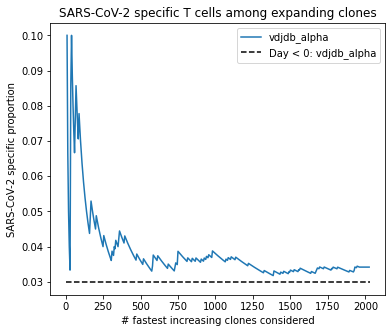

In [44]:
db = ['vdjdb_alpha']

plt.figure(figsize=(6,5))
for i, (db_i, color) in enumerate(zip(db, [matplotlib.cm.get_cmap('gray')(i/len(db)) for i in range(len(db))])):
    fractions = []
    for i in np.arange(10, 2030, 5):
        fractions.append([
            i,
            clone_df.sort_values('freq_increase')[-i:][db_i].mean()])    
    plt.plot(np.array(fractions)[:,0],np.array(fractions)[:,1], label=db_i)
    plt.xlabel('# fastest increasing clones considered')
    plt.ylabel('SARS-CoV-2 specific proportion')
#     plt.title('VDJDB: SARS-CoV-2 specific fraction of increasing clones')
    plt.hlines(
        adata[adata.obs.days_since_posswab_new<0].obs.groupby('clone_id').mean().mean()[db_i],
        0,2030, label = f'Day < 0: {db_i}', color=color, linestyle='--')
plt.legend(bbox_to_anchor=(1,1))
plt.title('SARS-CoV-2 specific T cells among expanding clones')
plt.savefig(savedir+'vdjdb_alpha_expanding_clones.pdf')

## Celltypist: Activated T cells

In [ ]:
adata.X = adata.layers['logcounts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
predictions = celltypist.annotate(adata, model='COVID19_HumanChallenge_Blood.pkl', )
adata.obs['celltypist_challenge'] = predictions.predicted_labels

In [ ]:
adata.obs['celltypist_challenge_wo_cycling'] = adata.obs.celltypist_challenge.str.split(' Cycling', expand=True)[0]
adata.obs['activated'] = adata.obs.celltypist_challenge_wo_cycling.str.contains('Activated')

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 38 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'H', 'I', 'L', 'M', 'N', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 36, 38, 39, 43, 44, 47, 48, 49, 53, 55, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
Closed glyph list over 'GSUB': 43 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'H', 'I', 'L', 'M', 'N', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'uniFB00', 'uniFB03', 'uniFB04', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 

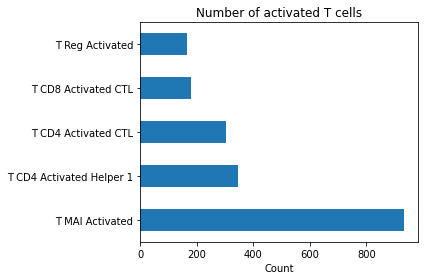

In [155]:
# mark activated T cells, ignoring MAIT cells
# adata.obs['activated'] = adata.obs.celltypist_/challenge.str.contains('Activated')# & ~ adata.obs.celltypist_challenge.str.contains('MAI')

# visualise results
adata[adata.obs.activated].obs.celltypist_challenge_wo_cycling.value_counts().plot.barh(title='Number of activated T cells', xlabel='Count')
plt.ylabel(None)
plt.xlabel('Count')
plt.tight_layout()
plt.savefig(savedir+'activated_w_MAIT_total_counts.pdf')

In [132]:
# make manual bins for time points
def get_day_bin(day):
    if day < 0 :
        return 'pre-pandemic'
    elif day < 4:
        return '0-3'
    elif day < 7:
        return '4-6'
    elif day < 10:
        return '7-10'
    elif day < 15:
        return '11-14'
    elif day < 19:
        return '15-18'
    elif day < 30:
        return '19-21'
    elif day > 30:
        return '40-55'
    else:
        return 'undefined'

adata.obs['day_bin'] = adata.obs.days_since_posswab_new.apply(get_day_bin)

In [133]:
day_bin_order = ['pre-pandemic', '0-3', '4-6', '7-10', '11-14', '15-18', '19-21', '40-55']
# day_bin_order = ['pre-pandemic', '0-5', '6-10', '11-15', '16-20', '40-55']

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 47 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'H', 'I', 'L', 'M', 'N', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'z', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 39, 43, 44, 47, 48, 49, 53, 55, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 93, 3228]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'H', 'I', 'L', 'M', 'N', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one',

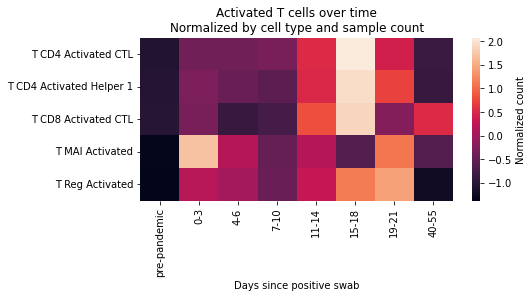

In [146]:
# all activated, but cycling merged into non-cycling
# divide by samples per day
data_hm = pd.crosstab(adata.obs['day_bin'], adata.obs.celltypist_challenge_wo_cycling).loc[day_bin_order,[i for i in adata.obs.celltypist_challenge_wo_cycling.unique() if 'Activated' in i]]
hm_norm = data_hm.div(adata.obs.groupby('day_bin').sample_id.nunique().loc[day_bin_order], axis=0)
hm_norm = ((hm_norm-hm_norm.mean())/hm_norm.std()).T
plt.figure(figsize=(7,3))
sns.heatmap(hm_norm.sort_index(), cbar_kws={'label':'Normalized count'})
plt.title('Activated T cells over time\nNormalized by cell type and sample count')
plt.xlabel('Days since positive swab')
plt.ylabel(None)
plt.savefig(savedir+'activated_by_binned_time_point.pdf')

In [34]:
clone_day_df = adata[adata.obs.clone_id.isin(sampled_before_and_after_10)].obs[[
    'clone_id','days_since_posswab_new', 'patient_id', 'activated',
    'vdjdb_alpha','vdjdb_beta','vdjdb_paired','clone_freq','clone_multiplicity'
]].drop_duplicates().reset_index(drop=True)

clone_df = clone_day_df.groupby(['clone_id']).mean()
clone_df['freq_before_10'] = clone_day_df[clone_day_df.days_since_posswab_new<10].groupby(['clone_id']).clone_freq.mean()
clone_df['freq_after_10'] = clone_day_df[clone_day_df.days_since_posswab_new>=10].groupby(['clone_id']).clone_freq.mean()
clone_df['freq_increase'] = clone_df.freq_after_10/clone_df.freq_before_10
# clone_df

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 38 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'D', 'P', 'T', 'a', 'c', 'colon', 'd', 'e', 'f', 'five', 'four', 'g', 'i', 'l', 'less', 'm', 'n', 'nonmarkingreturn', 'numbersign', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 6, 17, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 36, 39, 51, 55, 68, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92]
Closed glyph list over 'GSUB': 43 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'D', 'P', 'T', 'a', 'c', 'colon', 'd', 'e', 'f', 'fi', 'five', 'fl', 'four', 'g', 'i', 'l', 'less', 'm', 'n', 'nonmarkingreturn', 'numbersign', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'uniFB00', 'uniFB03', 'uniFB04', 'v

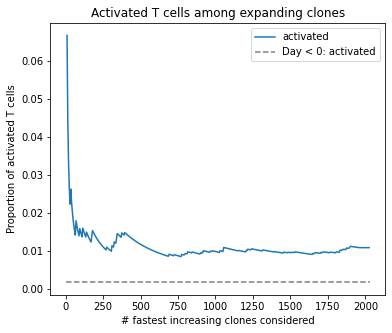

In [37]:
db_i = 'activated'
plt.figure(figsize=(6,5))
fractions = []
for i in np.arange(10, 2030, 5):
    fractions.append([
        i,
        clone_df.sort_values('freq_increase')[-i:][db_i].mean()])    
plt.plot(np.array(fractions)[:,0],np.array(fractions)[:,1], label=db_i)
plt.xlabel('# fastest increasing clones considered')
plt.ylabel('Proportion of activated T cells')
plt.hlines(
    adata[adata.obs.days_since_posswab_new<0].obs.groupby('clone_id').mean().mean()[db_i],
    0,2030, label = f'Day < 0: {db_i}', color='grey', linestyle='--')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Activated T cells among expanding clones')
plt.savefig(savedir+'fastest_increasing_activated.pdf')

## Cell2TCR

In [4]:
df = adata.obs.copy()

In [5]:
df['individual'] = df['patient_id']

# format to match Scirpy
for i, j in zip(
    ['IR_VDJ_1_junction_aa','IR_VDJ_1_v_call','IR_VDJ_1_j_call','IR_VJ_1_junction_aa','IR_VJ_1_v_call','IR_VJ_1_j_call'], # Scirpy format - leave unchanged
    ['IR_VDJ_1_cdr3_tcr','IR_VDJ_1_v_gene_tcr','IR_VDJ_1_j_gene_tcr','IR_VJ_1_cdr3_tcr','IR_VJ_1_v_gene_tcr','IR_VJ_1_j_gene_tcr']): # your format - modify to match your column names
    df.loc[:,i] = df.loc[:,j].copy()

In [9]:
df_freq_increasing_early_mid_late = df[df['freq_increasing_early_mid_late']]
df_freq_increasing_early_late = df[df['freq_increasing_early_late']]

In [10]:
cell2tcr.motifs(df_freq_increasing_early_late, sparse=True, chunk_size=100) 

/home/jovyan/my-conda-envs/scVI/lib/python3.10/site-packages/cell2tcr/functions.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,i] = df.loc[:,j]
/home/jovyan/my-conda-envs/scVI/lib/python3.10/site-packages/cell2tcr/functions.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,i] = df.loc[:,j]
/home/jovyan/my-conda-envs/scVI/lib/python3.10/site-packages/cell2tcr/functions.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [15]:
df_freq_increasing_early_late.to_csv('/nfs/team205/ld21/renal/vdj_motifs.csv')

In [11]:
df_freq_increasing_early_late.groupby('motif').subject.nunique().ge(2).to_frame().query('subject==True').shape

(99, 1)

In [13]:
df_freq_increasing_early_late.groupby('motif').subject.nunique().ge(3).to_frame().query('subject==True').shape

(9, 1)

In [15]:
df_freq_increasing_early_late.groupby('motif').subject.nunique().ge(4).to_frame().query('subject==True').shape

(3, 1)

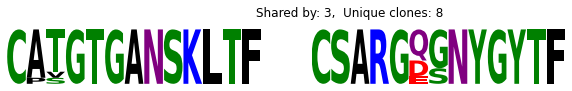

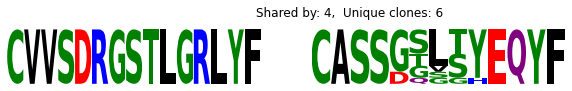

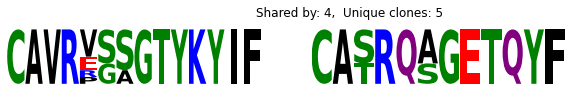

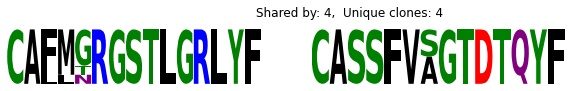

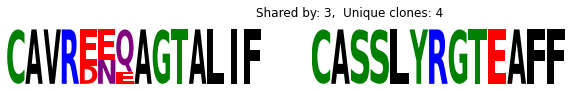

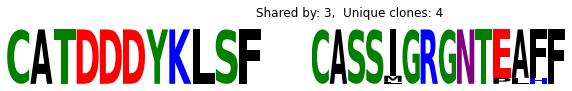

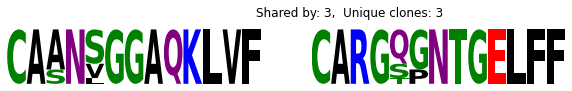

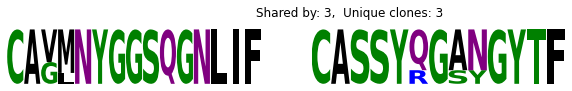

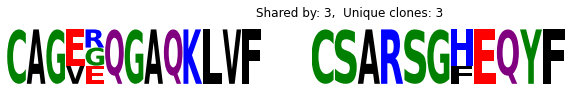

In [14]:
# for i in range(20):
for i in df_freq_increasing_early_late.groupby('motif').subject.nunique().ge(3).to_frame().query('subject==True').index.values:
    cell2tcr.draw_cdr3(df_freq_increasing_early_late.query(f'motif=={i}'))#, savefig_title=savedir+f'motif_{i}.pdf')

## Are motifs shared across Cohort 2020 and Cohort 2021 ?

In [ ]:
# Caution: this file is not the same result as obtained with jHub code above
df = pd.read_csv('/nfs/team205/ld21/renal/vdj_motifs.csv')

In [19]:
df_freq_increasing_early_late.groupby('motif').nunique().centre.eq(2).mean()

0.0007624534056252118

In [38]:
shared_motifs = df_freq_increasing_early_late.groupby('motif').nunique().individual.ge(2).to_frame().query('individual==True').index.tolist()
len(shared_motifs)

99

In [37]:
df_freq_increasing_early_late[df_freq_increasing_early_late.motif.isin(shared_motifs)].groupby('motif').nunique().centre.eq(2).mean()

0.36363636363636365

How likely is this percentage of cross-wave sharing to occur, given the number of shared motifs and participants from the 2 waves?
- 99 shared motifs
- from 18 NCL / 14 Cambridge participants (56%-44%)
- 36/99 are shared cross-wave (36%)

In [31]:
df_freq_increasing_early_late[df_freq_increasing_early_late.motif.isin(shared_motifs)].drop_duplicates('individual').centre.value_counts(normalize=True)

NCL          0.5625
Cambridge    0.4375
Name: centre, dtype: float64

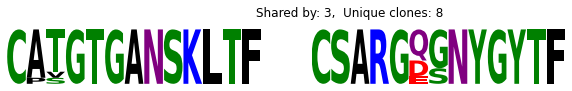

NCL          3
Cambridge    0
Name: centre, dtype: int64


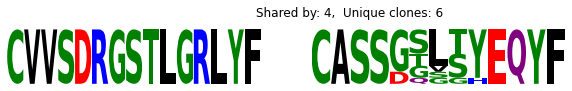

Cambridge    2
NCL          2
Name: centre, dtype: int64


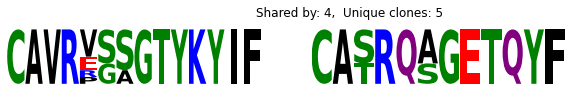

NCL          4
Cambridge    0
Name: centre, dtype: int64


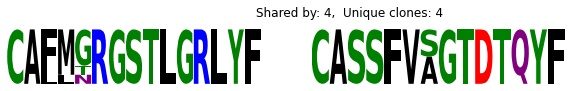

NCL          4
Cambridge    0
Name: centre, dtype: int64


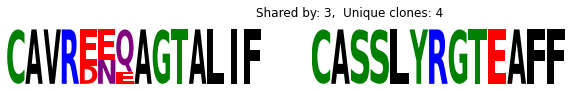

Cambridge    2
NCL          1
Name: centre, dtype: int64


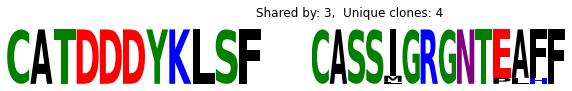

Cambridge    3
NCL          0
Name: centre, dtype: int64


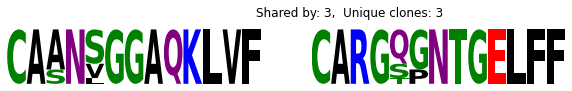

Cambridge    2
NCL          1
Name: centre, dtype: int64


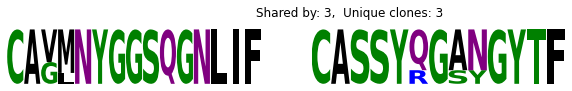

NCL          3
Cambridge    0
Name: centre, dtype: int64


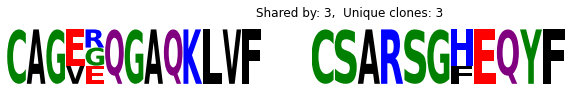

NCL          2
Cambridge    1
Name: centre, dtype: int64


In [16]:
# for i in range(20):
for i in df_freq_increasing_early_late.groupby('motif').subject.nunique().ge(3).to_frame().query('subject==True').index.values:
    cell2tcr.draw_cdr3(df_freq_increasing_early_late.query(f'motif=={i}'))#, savefig_title=savedir+f'motif_{i}.pdf')
    print(df_freq_increasing_early_late.query(f'motif=={i}').drop_duplicates('patient_id').centre.value_counts())